In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

palette = sns.husl_palette(s=1)
sns.set(style='whitegrid', palette=palette, context='talk')

### Load data

In [2]:
df = pd.read_csv('train.csv', parse_dates=True)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


### Train-test-split

In [4]:
X = df.iloc[:,:]
y = df['count']

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=4)
X_train.shape, X_val.shape, y_train.shape, y_val.shape
X_train.reset_index(inplace=True)

## Feature Engineering

Shift temperature too temperature with maximum count = 35

In [9]:
# Create additional features
def feat_eng(X):
    X_temp = X
    X_temp['atemp_shift'] = abs(X_temp['atemp'] - 35)
    X_temp['datetime'] = pd.to_datetime(X_temp['datetime'])
    # Extract all time information
    X_temp['datetime_hour'] = X_temp['datetime'].dt.hour # important _ onehot
    X_temp['datetime_day'] = X_temp['datetime'].dt.day
    X_temp['datetime_month'] = X_temp['datetime'].dt.month # use month as onehot or factorized instead of season
    X_temp['datetime_year'] = X_temp['datetime'].dt.year # maybe instead of timestamp
    X_temp['datetime_weekdays'] = X_temp['datetime'].dt.day_name()
    X_temp['timestamp'] = X_temp['datetime'].astype(int) / 1_000_000_000_000_000_000
    X_temp['hour_workday'] = X_temp['datetime_hour'] * X_temp['workingday']
    X_temp['hour_weekend'] = X_temp['datetime_hour'] * (X_temp['workingday'] - 1) * (-1)
    
feat_eng(X_train)
#X_val = feat_eng(X_val)

TypeError: 'NoneType' object is not subscriptable

In [12]:
# One-Hot-Encoding
from sklearn.preprocessing import OneHotEncoder
ohc = OneHotEncoder(sparse=False, handle_unknown='ignore')
onehot_columns = ohc.get_feature_names(['month', 'weather', 'hour_workday', 'hour_weekend'])

X_train_onehot = ohc.fit_transform(X_train[['datetime_month', 'weather', 'hour_workday', 'hour_weekend']])
X_train_onehot = pd.DataFrame(onehot, columns=onehot_columns)

X_val_onehot = ohc.transform(X_val[['datetime_month', 'weather', 'hour_workday', 'hour_weekend']])
X_val_onehot = pd.DataFrame(onehot, columns=onehot_columns)

In [18]:
X_train = X_train[['datetime_year', 'workingday', 'atemp_shift', 'humidity', 'windspeed']]
X_train = pd.concat([X_train, onehot], axis=1)

X_val = X_val[['datetime_year', 'workingday', 'atemp_shift', 'humidity', 'windspeed']]
X_val = pd.concat([X_val, onehot], axis=1)

onehot.shape, X_train_model.shape, X_train_model_onehot.shape

((8708, 64), (8708, 5), (8708, 69))

## Set up the model

In [17]:
from sklearn.linear_model import LinearRegression

#### Scale the data

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # scales each column to minimum 0.0 and maximum 1.0. Makes sure all data fits together.
scaler.fit(X_train_model_onehot)
X_scaled = scaler.transform(X_train_model_onehot) # later just use transform on X_test, DO NOT FIT AGAIN

In [20]:
y_train_cas = X_train['casual']
lr_cas = LinearRegression()
lr_cas.fit(X_scaled, np.log(y_train_cas+1))
lr_cas.score(X_scaled, np.log(y_train_cas+1))

0.8567973167206395

In [21]:
y_train_reg = X_train['registered']
lr_reg = LinearRegression()
lr_reg.fit(X_scaled, np.log(y_train_reg+1))
lr_reg.score(X_scaled, np.log(y_train_reg+1))

0.9409667952883678

In [22]:
X_train_model_onehot.shape, y_train_cas.shape

((8708, 69), (8708,))

Cross validation

In [23]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr_reg, X_scaled, np.log(y_train+1), cv=4, scoring='r2')
scores

array([-2.72671773e+19,  9.37747909e-01,  9.35354899e-01,  9.38048124e-01])

In [24]:
scores.mean().round(3), scores.std().round(3)

(-6.816794336309205e+18, 1.180703413523531e+19)

In [87]:
X_train['cas_pred'] = np.exp(lr_cas.predict(X_scaled))
X_train['reg_pred'] = np.exp(lr_reg.predict(X_scaled))
X_train['count_pred'] = X_train['cas_pred'] + X_train['reg_pred']
X_train['count_pred']

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/julia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/julia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

0       126.116384
1       218.994244
2       169.768991
3       146.281903
4         6.779313
           ...    
8703     60.814248
8704     63.418010
8705    308.838304
8706    129.731281
8707    111.698244
Name: count_pred, Length: 8708, dtype: float64

In [26]:
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(y_train, X_train['count_pred']))

0.3581745853117951

In [27]:
from sklearn.metrics import r2_score
r2_score(y_train, X_train['count_pred'])

0.9067885000781236

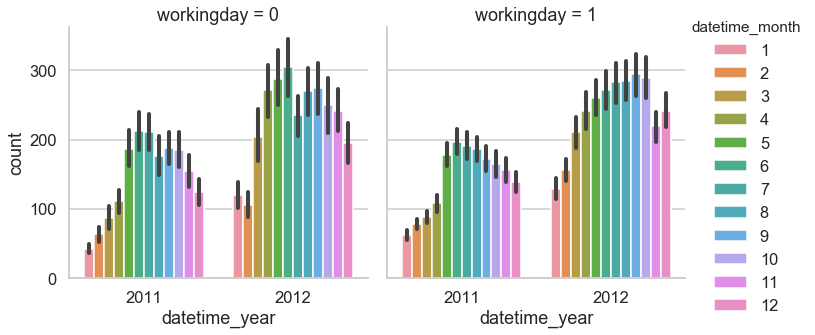

In [38]:
g = sns.catplot(x='datetime_year', y='count', kind='bar', hue = 'datetime_month', col = 'workingday', data=X_train)

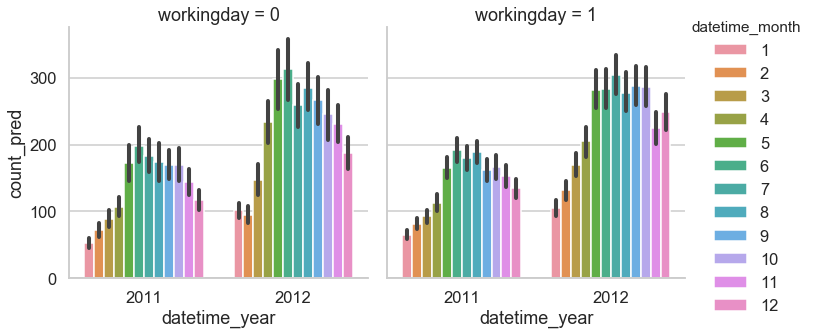

In [39]:
g = sns.catplot(x='datetime_year', y='count_pred', kind='bar', hue = 'datetime_month', col = 'workingday', data=X_train)

In [40]:
lr_reg.coef_, lr_cas.coef_

(array([ 5.16463694e-01, -1.01547112e+00, -7.15375613e-01, -2.12943256e-01,
        -1.65936587e-01,  2.18686099e+10,  2.18686099e+10,  2.18686099e+10,
         2.18686099e+10,  2.18686099e+10,  2.18686099e+10,  2.18686099e+10,
         2.18686099e+10,  2.18686099e+10,  2.18686099e+10,  2.18686099e+10,
         2.18686099e+10, -8.00675894e+10, -8.00675894e+10, -8.00675894e+10,
        -8.00675894e+10,  8.59856948e+10,  8.59856948e+10,  8.59856948e+10,
         8.59856948e+10,  8.59856948e+10,  8.59856948e+10,  8.59856948e+10,
         8.59856948e+10,  8.59856948e+10,  8.59856948e+10,  8.59856948e+10,
         8.59856948e+10,  8.59856948e+10,  8.59856948e+10,  8.59856948e+10,
         8.59856948e+10,  8.59856948e+10,  8.59856948e+10,  8.59856948e+10,
         8.59856948e+10,  8.59856948e+10,  8.59856948e+10,  8.59856948e+10,
         8.59856948e+10, -2.32364006e+10, -2.32364006e+10, -2.32364006e+10,
        -2.32364006e+10, -2.32364006e+10, -2.32364006e+10, -2.32364006e+10,
        -2.3

In [41]:
X_train['count_residual'] = X_train['count_pred'] - X_train['count']

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


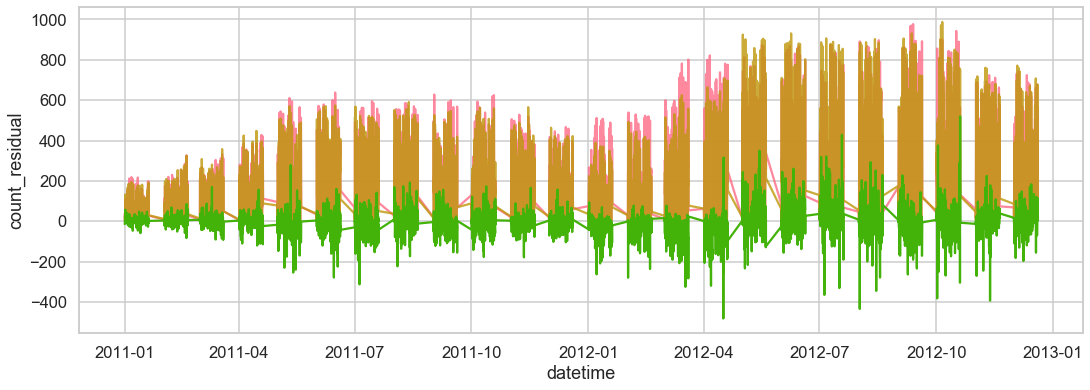

In [42]:
fig = plt.figure(figsize=(18,6))
ax = sns.lineplot(x='datetime', y='count', data=X_train, alpha = 0.8)
ax = sns.lineplot(x='datetime', y='count_pred', data=X_train, alpha = 0.8)
ax = sns.lineplot(x='datetime', y='count_residual', data=X_train)
#ax.set_xlim(pd.Timestamp('2011-04-01'), pd.Timestamp('2011-09-01'))

In [33]:
X_train['count_residual'].min(), X_train['count_residual'].max(),  X_train['count_residual'].isna().sum()

(-481.3880829713653, 519.8977275006296, 0)

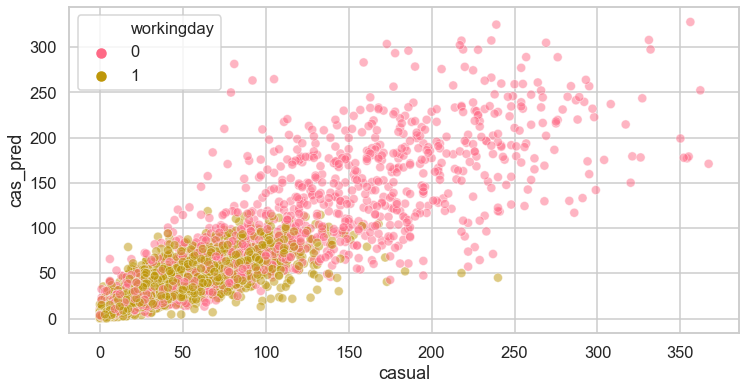

In [90]:
fig = plt.figure(figsize=(12,6))
ax = sns.scatterplot(x='casual', y='cas_pred', hue='workingday', data=X_train, alpha = 0.5)

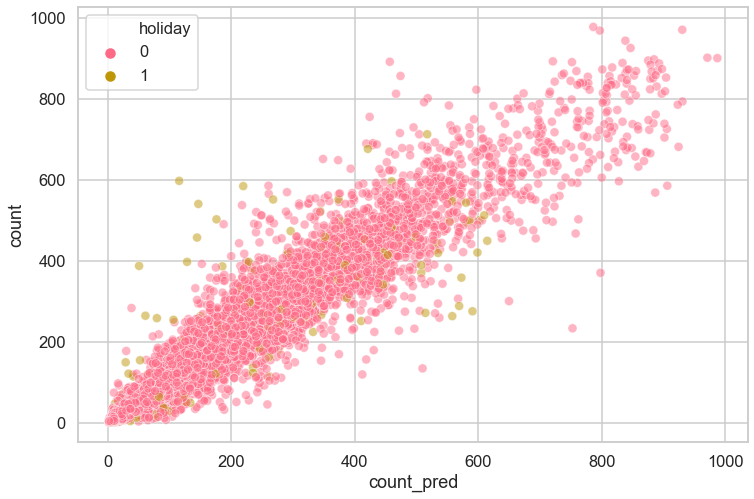

In [47]:
fig = plt.figure(figsize=(12,8))
ax = sns.scatterplot(x='count_pred', y='count', hue='holiday', data=X_train, alpha = 0.5)

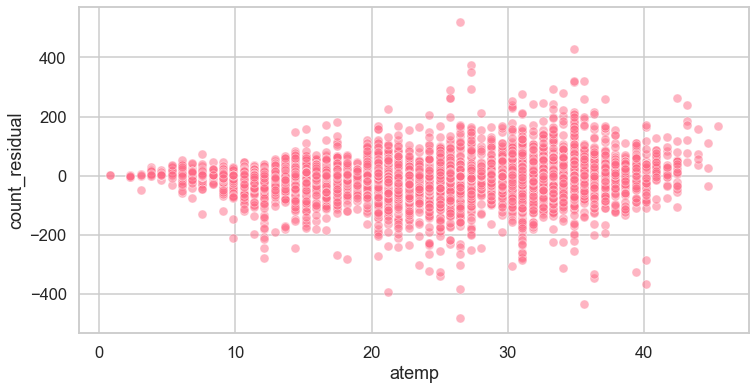

In [34]:
fig = plt.figure(figsize=(12,6))
ax = sns.scatterplot(x='atemp', y='count_residual', data=X_train, alpha = 0.5)

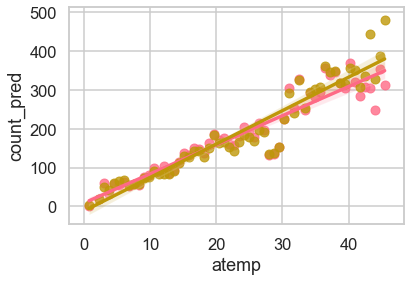

In [35]:
temp_penalty = X_train.groupby('atemp')[['atemp', 'count','count_pred', 'count_residual']].mean()
sns.regplot(x='atemp', y='count', data=temp_penalty)
sns.regplot(x='atemp', y='count_pred', data=temp_penalty)
#sns.catplot(x='atemp', y='count_residual', data=temp_penalty)

In [36]:
X_train[X_train['count_residual'] < -300]

,index,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,...,datetime_month,datetime_year,datetime_weekdays,timestamp,hour_workday,hour_weekend,cas_pred,reg_pred,count_pred,count_residual
1801,9536,2012-10-01 17:00:00,4,0,1,3,22.96,26.515,60,16.9979,...,10,2012,Monday,1.349111,17,0,35.101530,439.115124,474.216653,-381.783347
2706,7150,2012-04-16 07:00:00,2,1,0,1,21.32,25.000,83,8.9981,...,4,2012,Monday,1.334560,0,7,11.795725,38.855371,50.651096,-336.348904
3413,8936,2012-08-14 17:00:00,3,0,1,3,31.16,36.365,66,16.9979,...,8,2012,Tuesday,1.344964,17,0,44.442962,422.566833,467.009795,-344.990205
3473,9967,2012-10-19 16:00:00,4,0,1,3,25.42,30.305,69,23.9994,...,10,2012,Friday,1.350662,16,0,31.912550,228.860385,260.772935,-304.227065
3510,2783,2011-07-04 21:00:00,3,1,0,2,30.34,34.090,62,7.0015,...,7,2011,Monday,1.309813,0,21,47.651609,96.918154,144.569763,-312.430237
4585,8625,2012-08-01 18:00:00,3,0,1,3,31.16,35.605,62,15.0013,...,8,2012,Wednesday,1.343844,18,0,40.959647,415.894949,456.854595,-434.145405
4935,6918,2012-04-06 14:00:00,2,0,1,1,19.68,23.485,29,26.0027,...,4,2012,Friday,1.333721,14,0,45.214532,142.373942,187.588474,-302.411526
5064,6724,2012-03-17 11:00:00,1,0,0,2,21.32,25.000,77,8.9981,...,3,2012,Saturday,1.331982,0,11,79.025910,181.239018,260.264928,-324.735072
5372,8245,2012-07-04 22:00:00,3,1,0,1,33.62,39.395,56,15.0013,...,7,2012,Wednesday,1.341439,0,22,42.805646,133.268696,176.074342,-325.925658
6296,8244,2012-07-04 21:00:00,3,1,0,1,34.44,40.150,53,8.9981,...,7,2012,Wednesday,1.341436,0,21,57.430594,161.988195,219.418789,-364.581211
